# Analyse cupy logs

## array() timings in cupy/cupy/core/core.pyx

In [90]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path
import datetime
from cycler import cycler
import pandas as pd

In [91]:
!ls cupy*.log

cupy_logs064.log cupy_logs128.log


In [92]:
filename="cupy_logs064.log"

In [93]:
df = pd.read_csv(filename,header=0, skiprows=[0])
df.iloc[:5]

,timestamp,timedelta,time_cuda,shape
0,2018-02-26 06:23:47.794283,0.001021,1.029952,(512:)
1,2018-02-26 06:23:47.794585,0.000066,0.069920,(512:)
2,2018-02-26 06:23:47.810540,0.000061,0.006496,(512:)
3,2018-02-26 06:23:47.810666,0.000046,0.050560,(512:)
4,2018-02-26 06:23:47.810778,0.000045,0.048096,(512:)


In [94]:
# Parse date from readable format to seconds
start = 0
def parseTime(date_time):
    global start
    dt_obj = datetime.datetime.strptime(date_time, "%Y-%m-%d %H:%M:%S.%f")
    seconds = 0
    if start == 0:
        start = dt_obj
    else:
        seconds = (dt_obj - start).total_seconds()
    return seconds

In [95]:
df["sec"] = df.timestamp.apply(parseTime)
df.iloc[:5]

,timestamp,timedelta,time_cuda,shape,sec
0,2018-02-26 06:23:47.794283,0.001021,1.029952,(512:),0.000000
1,2018-02-26 06:23:47.794585,0.000066,0.069920,(512:),0.000302
2,2018-02-26 06:23:47.810540,0.000061,0.006496,(512:),0.016257
3,2018-02-26 06:23:47.810666,0.000046,0.050560,(512:),0.016383
4,2018-02-26 06:23:47.810778,0.000045,0.048096,(512:),0.016495


In [96]:
df.set_index("sec", drop=True, inplace=True)
df = df.drop(columns=['timestamp'])
df.iloc[:5]

,timedelta,time_cuda,shape
sec,,,
0.000000,0.001021,1.029952,(512:)
0.000302,0.000066,0.069920,(512:)
0.016257,0.000061,0.006496,(512:)
0.016383,0.000046,0.050560,(512:)
0.016495,0.000045,0.048096,(512:)


In [98]:
gr = df.groupby(by="shape").agg({"timedelta": [np.mean, np.count_nonzero, np.sum]})
grr = gr.reset_index()
grr.columns=["shape","mean","count","sum"]
print "time:",grr["sum"].sum(),"(ms)"
print "calls:",grr["count"].sum()
grr

time: 0.168833 (ms)
calls: 2901.0


,shape,mean,count,sum
0,(),0.000004,939.0,0.003456
1,(128:),0.000041,12.0,0.000489
2,(16: 3: 32: 32),0.000727,1.0,0.000727
3,(16:),0.000046,1.0,0.000046
4,(256:),0.000044,18.0,0.000799
5,(512:),0.000066,42.0,0.002769
6,(64: 3: 32: 32),0.000114,938.0,0.106514
7,(64:),0.000057,950.0,0.054033


In [76]:
grr.set_index("shape",inplace=True)

In [78]:
grr.sort_values("sum",ascending=False)

,mean,count,sum
shape,,,
(64: 3: 32: 32),0.083907,938.0,78.704960
(64:),0.059166,950.0,56.207744
(512:),0.082848,42.0,3.479616
(),0.001027,939.0,0.964608
(256:),0.045465,18.0,0.818368
(16: 3: 32: 32),0.750144,1.0,0.750144
(128:),0.043400,12.0,0.520800
(16:),0.047456,1.0,0.047456


In [89]:
print grr["sum"].sum(),"(ms)"
print grr["count"].sum(),"calls"

141.493696058 (ms)
2901.0 calls


In [51]:
pv = df.pivot(columns="shape", values="time_delta").fillna(0)
pv

shape,(),(128:),(16: 3: 32: 32),(16:),(256:),(512:),(64: 3: 32: 32),(64:)
sec,,,,,,,,
0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.015712,0.000000,0.000000
0.000302,0.000000,0.0,0.000000,0.000000,0.0,0.051616,0.000000,0.000000
0.000467,0.000000,0.0,0.000000,0.000000,0.0,0.061312,0.000000,0.000000
0.000574,0.000000,0.0,0.000000,0.000000,0.0,0.044256,0.000000,0.000000
0.000678,0.000000,0.0,0.000000,0.000000,0.0,0.043840,0.000000,0.000000
0.000780,0.000000,0.0,0.000000,0.000000,0.0,0.043616,0.000000,0.000000
0.000918,0.000000,0.0,0.000000,0.000000,0.0,0.044512,0.000000,0.000000
0.001018,0.000000,0.0,0.000000,0.000000,0.0,0.042368,0.000000,0.000000
0.001118,0.000000,0.0,0.000000,0.000000,0.0,0.041728,0.000000,0.000000


(0, 1.1)

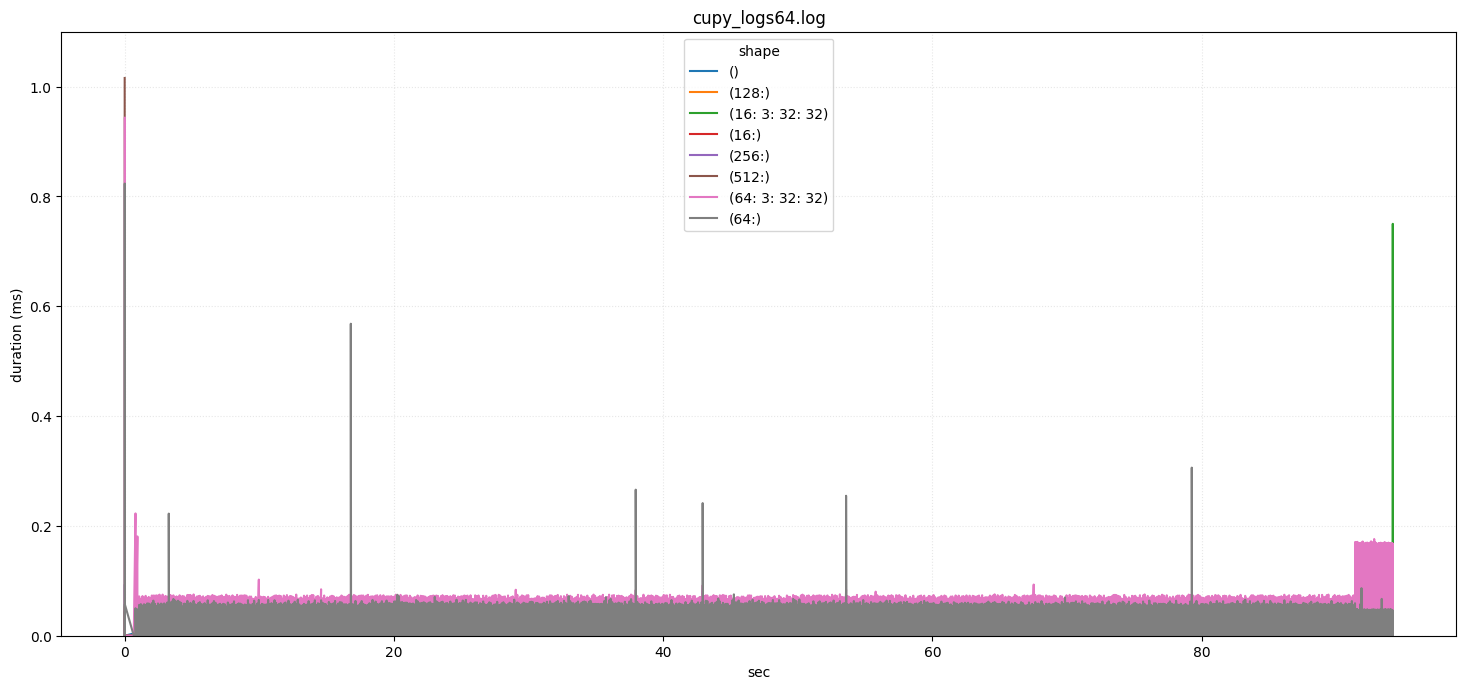

In [88]:
ax = pv.plot(figsize=(18,8))
ax.set_title(filename)
ax.set_ylabel("duration (ms)")
ax.grid('on', alpha=0.3, ls=":")
ax.set_ylim(0,1.1)